In [ ]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

In [1]:
from os.path import join

import numpy as np
import pandas as pd
import lightning.pytorch as pl
import dask.dataframe as dd

from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [2]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

NEW_MODEL = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default/augment_2/checkpoints/val_f1_macro_epoch=48_val_f1_macro=0.850.ckpt'
OLD_MODEL = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default/subset_15_1/checkpoints/val_f1_macro_epoch=71_val_f1_macro=0.729.ckpt'

In [3]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
tissue_general_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/tissue_general.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
tissue_general = dd.read_parquet(join(DATA_PATH, 'test'), columns='tissue_general').compute().to_numpy()
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()

# Load models & predict

In [4]:
from utils import correct_labels

In [5]:
estim = EstimatorCellTypeClassifier(DATA_PATH)
estim.init_datamodule(batch_size=2048)
estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
estim.model = TabnetClassifier.load_from_checkpoint(NEW_MODEL, **estim.get_fixed_model_params('tabnet'))
y_pred_new = np.argmax(estim.predict(estim.datamodule.test_dataloader()), axis=1)
y_pred_new_corr = correct_labels(y_true, y_pred_new, cell_type_hierarchy)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 1684/1684 [04:04<00:00,  6.88it/s]


In [7]:
estim.model = TabnetClassifier.load_from_checkpoint(OLD_MODEL, **estim.get_fixed_model_params('tabnet'))
y_pred_old = np.argmax(estim.predict(estim.datamodule.test_dataloader()), axis=1)
y_pred_old_corr = correct_labels(y_true, y_pred_old, cell_type_hierarchy)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 1684/1684 [04:04<00:00,  6.89it/s]


# Classification performance

In [8]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

#### Overall performance

In [22]:
clf_report_new = pd.DataFrame(classification_report(y_true, y_pred_new_corr, output_dict=True)).T
clf_report_overall_new = clf_report_new.iloc[-3:].copy()
clf_report_per_class_new = clf_report_new.iloc[:-3].copy()

clf_report_overall_new

,precision,recall,f1-score,support
accuracy,0.906811,0.906811,0.906811,9.068111e-01
macro avg,0.824239,0.849110,0.829628,3.448832e+06
weighted avg,0.911289,0.906811,0.906950,3.448832e+06


In [23]:
clf_report_old = pd.DataFrame(classification_report(y_true, y_pred_old_corr, output_dict=True)).T
clf_report_overall_old = clf_report_old.iloc[-3:].copy()
clf_report_per_class_old = clf_report_old.iloc[:-3].copy()

clf_report_overall_old

,precision,recall,f1-score,support
accuracy,0.856283,0.856283,0.856283,8.562829e-01
macro avg,0.730494,0.753609,0.718662,3.448832e+06
weighted avg,0.872650,0.856283,0.858278,3.448832e+06


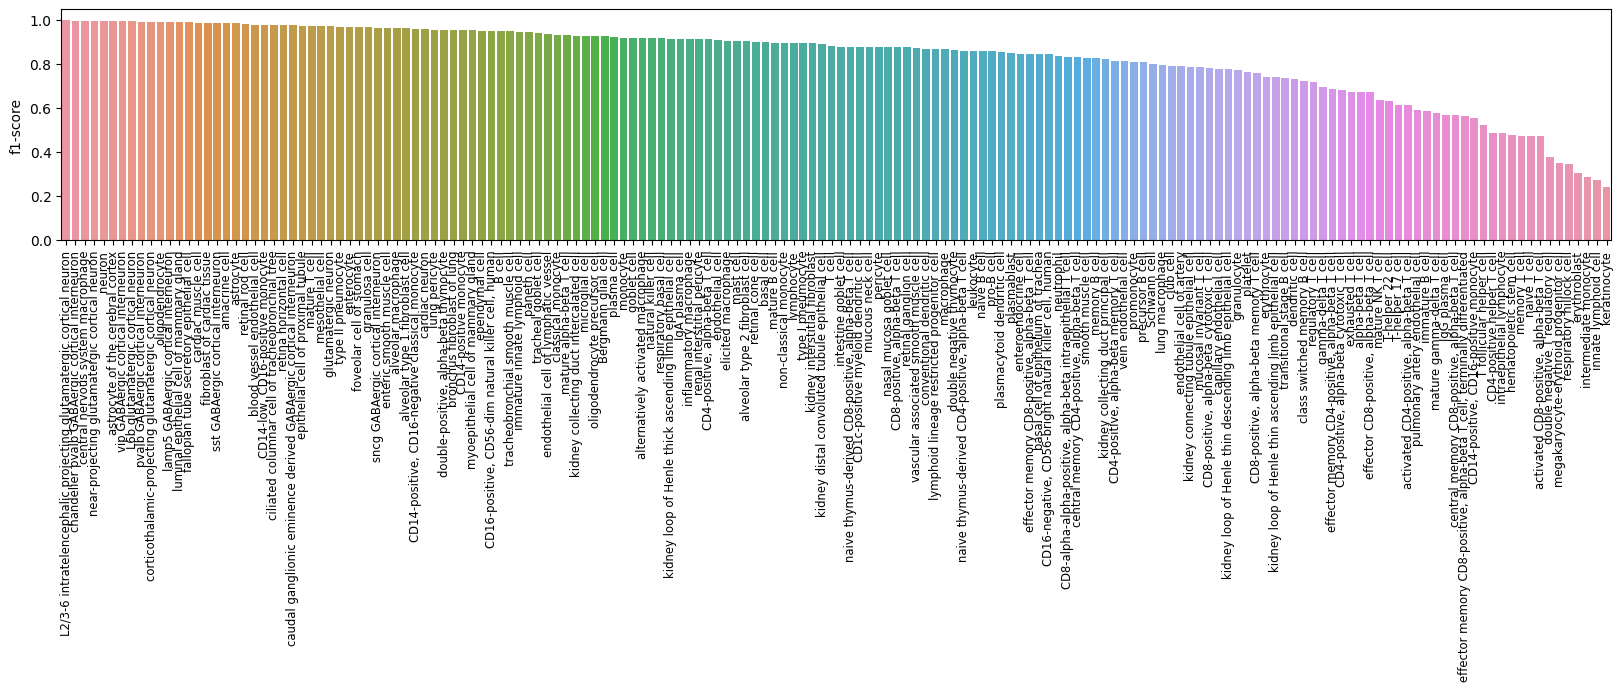

In [24]:
plt.rcParams['figure.figsize'] = (20, 3)

ax = sns.barplot(
    data=(
        clf_report_per_class_new
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
        )
        .sort_values('f1-score', ascending=False)
    ),
    x='cell_type',
    y='f1-score',
)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('')
ax.xaxis.set_tick_params(labelsize='small');

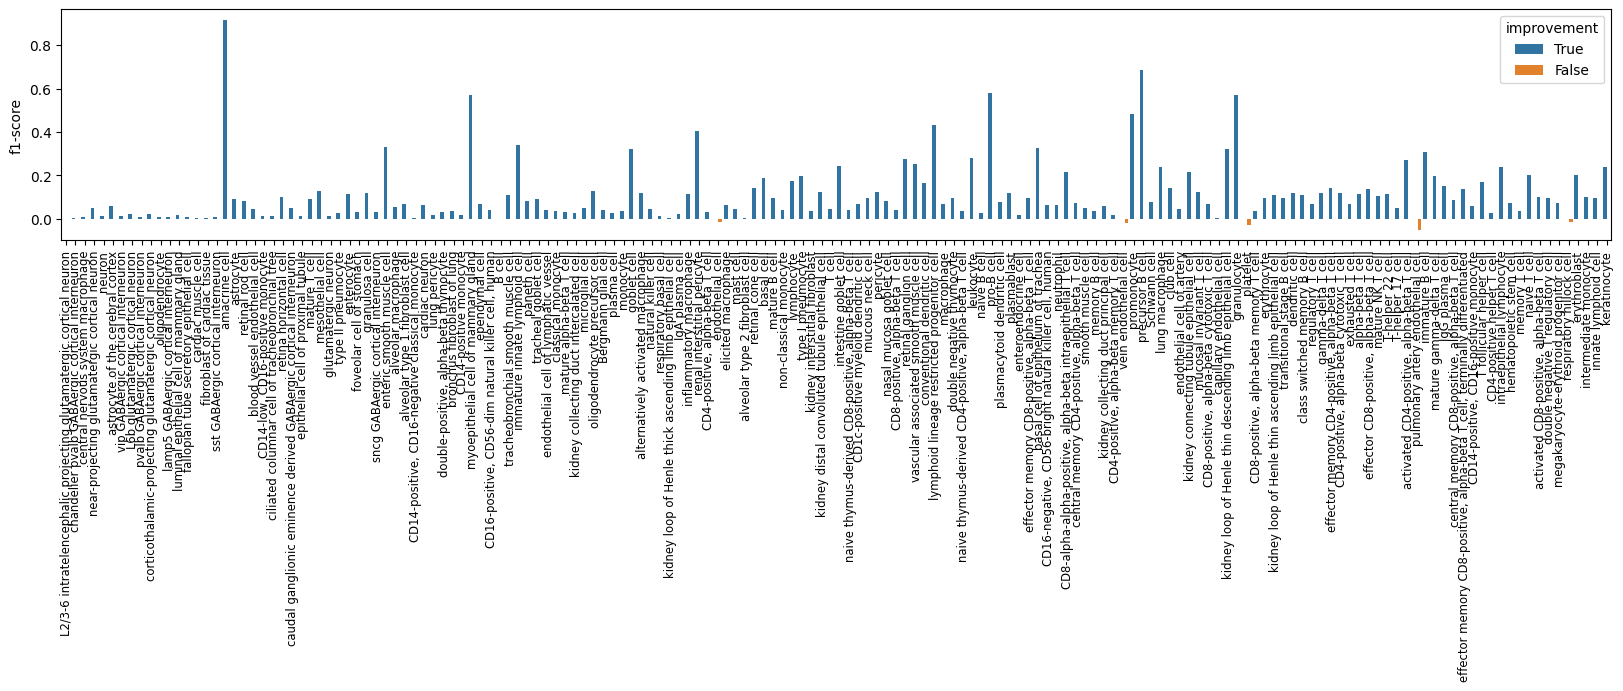

In [27]:
clf_report_per_class_diff = clf_report_per_class_new - clf_report_per_class_old
clf_report_per_class_diff['f1-score-new'] = clf_report_per_class_new['f1-score']
ax = sns.barplot(
    data=(
        clf_report_per_class_diff
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict()),
            improvement=lambda df: df['f1-score'] >= 0.
        )
        .sort_values('f1-score-new', ascending=False)
    ),
    x='cell_type',
    y='f1-score',
    hue='improvement',
    hue_order=[True, False]
)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('')
# ax.set_ylim(-1., 1.)
ax.xaxis.set_tick_params(labelsize='small');

# Classification performance per BioNetwork

In [13]:
from utils import BIONETWORK_GROUPING

In [14]:
preds_new_df = pd.DataFrame({
    'y_pred': y_pred_new_corr,
    'y_true': y_true,
    'tissue': tissue_general_mapping.loc[tissue_general].to_numpy().flatten()
})

preds_old_df = pd.DataFrame({
    'y_pred': y_pred_old_corr,
    'y_true': y_true,
    'tissue': tissue_general_mapping.loc[tissue_general].to_numpy().flatten()
})

In [15]:
clf_report_new_by_bionetwork = {}

for bionetwork, organs in BIONETWORK_GROUPING.items():
    df = preds_new_df[preds_new_df.tissue.isin(organs)]
    labels = df.y_true.unique()
    clf_report_new_by_bionetwork[bionetwork] = pd.DataFrame(
        classification_report(df.y_true.to_numpy(), df.y_pred.to_numpy(), labels=labels, zero_division=0, output_dict=True)
    ).T
    
    
clf_report_old_by_bionetwork = {}

for bionetwork, organs in BIONETWORK_GROUPING.items():
    df = preds_old_df[preds_old_df.tissue.isin(organs)]
    labels = df.y_true.unique()
    clf_report_old_by_bionetwork[bionetwork] = pd.DataFrame(
        classification_report(df.y_true.to_numpy(), df.y_pred.to_numpy(), labels=labels, zero_division=0, output_dict=True)
    ).T


In [16]:
f1_score_new_per_bionetwork = pd.DataFrame(
    [
        [
            network,
            clf_report.loc['macro avg', 'f1-score'],
            clf_report.loc['micro avg', 'f1-score'],
            clf_report.loc['macro avg', 'support'],
            len(clf_report) - 3
        ]
        for network, clf_report in clf_report_new_by_bionetwork.items()
    ],
    columns=['BioNetwork', 'f1-score (macro avg.)', 'accuracy', 'support', '# cell types'],
).assign(support=lambda df: df.support.astype(int))


f1_score_old_per_bionetwork = pd.DataFrame(
    [
        [
            network,
            clf_report.loc['macro avg', 'f1-score'],
            clf_report.loc['micro avg', 'f1-score'],
            clf_report.loc['macro avg', 'support'],
            len(clf_report) - 3
        ]
        for network, clf_report in clf_report_old_by_bionetwork.items()
    ],
    columns=['BioNetwork', 'f1-score (macro avg.)', 'accuracy', 'support', '# cell types'],
).assign(support=lambda df: df.support.astype(int))


f1_score_new_per_bionetwork['f1-score change'] = f1_score_new_per_bionetwork['f1-score (macro avg.)'] - f1_score_old_per_bionetwork['f1-score (macro avg.)']
f1_score_new_per_bionetwork['accuracy change'] = f1_score_new_per_bionetwork['accuracy'] - f1_score_old_per_bionetwork['accuracy']

In [17]:
print(f"f1-score (macro avg.) BioNetwork average: {f1_score_new_per_bionetwork['f1-score (macro avg.)'].mean():.3f}")
f1_score_change = (
    f1_score_new_per_bionetwork['f1-score (macro avg.)'].mean() - 
    f1_score_old_per_bionetwork['f1-score (macro avg.)'].mean()
)
print(f"f1-score change: {f1_score_change:.3f}")
print(f"accuracy BioNetwork average: {f1_score_new_per_bionetwork['accuracy'].mean():.3f}")
accuracy_change = (
    f1_score_new_per_bionetwork['accuracy'].mean() - 
    f1_score_old_per_bionetwork['accuracy'].mean()
)
print(f"accuracy change: {accuracy_change:.3f}")
print()
f1_score_new_per_bionetwork[['f1-score (macro avg.)', 'accuracy', 'f1-score change', 'accuracy change']] = f1_score_new_per_bionetwork[
    ['f1-score (macro avg.)', 'accuracy', 'f1-score change', 'accuracy change']
].applymap('{0:.3f}'.format)
f1_score_new_per_bionetwork

f1-score (macro avg.) BioNetwork average: 0.680
f1-score change: 0.130
accuracy BioNetwork average: 0.877
accuracy change: 0.077



,BioNetwork,f1-score (macro avg.),accuracy,support,# cell types,f1-score change,accuracy change
0,adipose,0.890,0.964,5168,14,0.044,0.054
1,breast,0.748,0.942,122879,42,0.098,0.108
2,eye,0.849,0.970,70415,20,0.262,0.178
3,gut,0.604,0.818,341466,87,0.128,0.054
4,heart,0.855,0.970,137235,23,0.083,0.029
5,blood_and_immune,0.713,0.881,1406331,81,0.104,0.044
6,kidney,0.737,0.925,79437,33,0.198,0.046
7,liver,0.531,0.798,52235,36,0.142,0.099
8,lung,0.687,0.898,398635,83,0.150,0.058
9,musculoskeletal,0.641,0.814,44982,52,0.184,0.177


**adipose:**

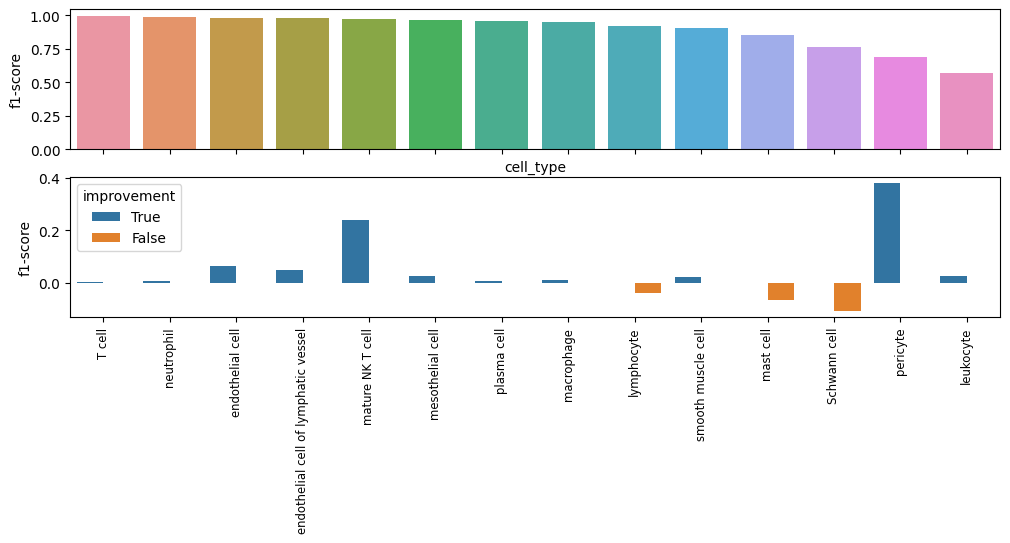

**breast:**

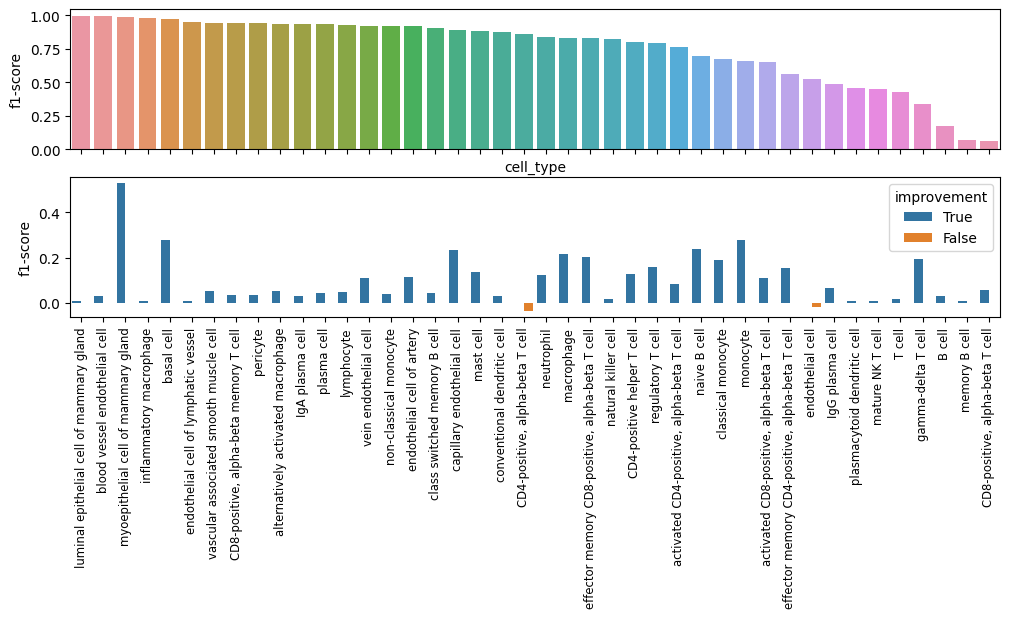

**eye:**

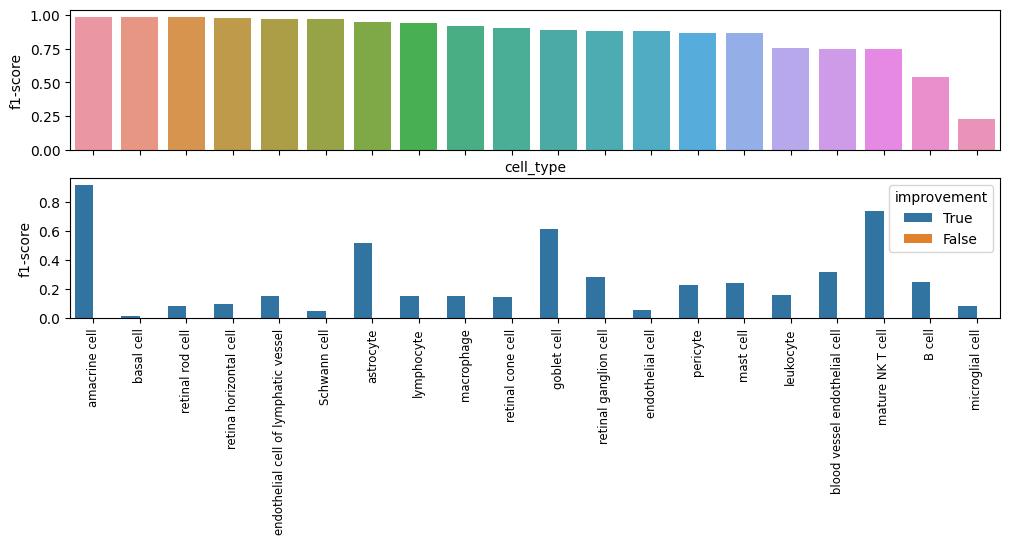

**gut:**

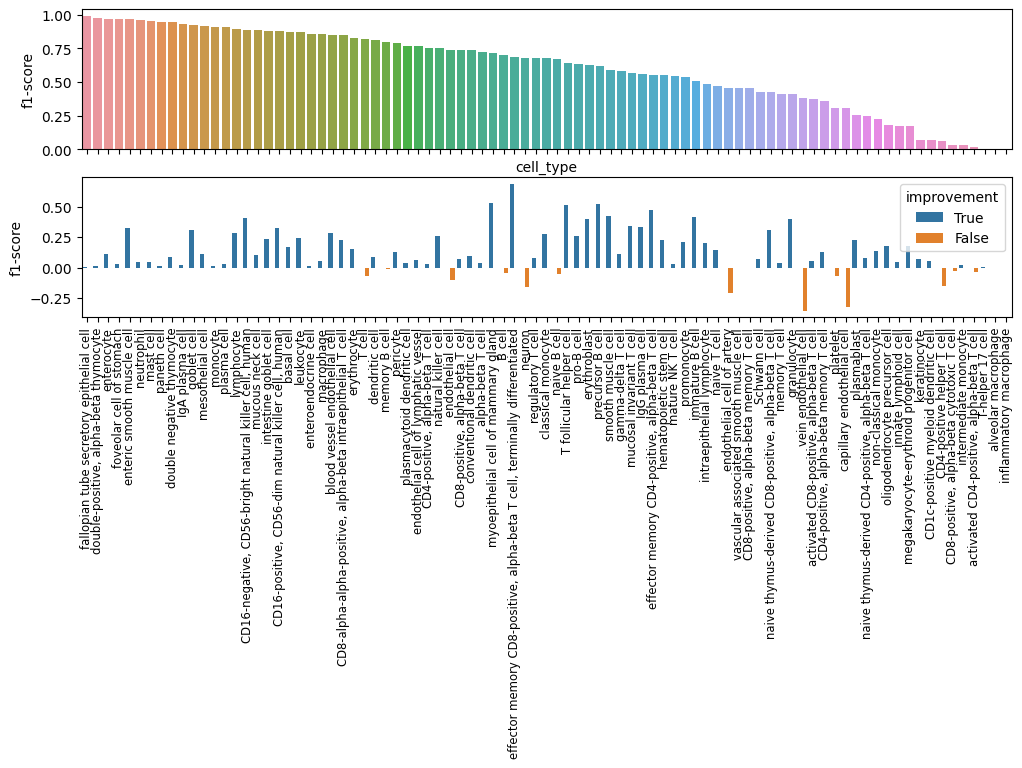

**heart:**

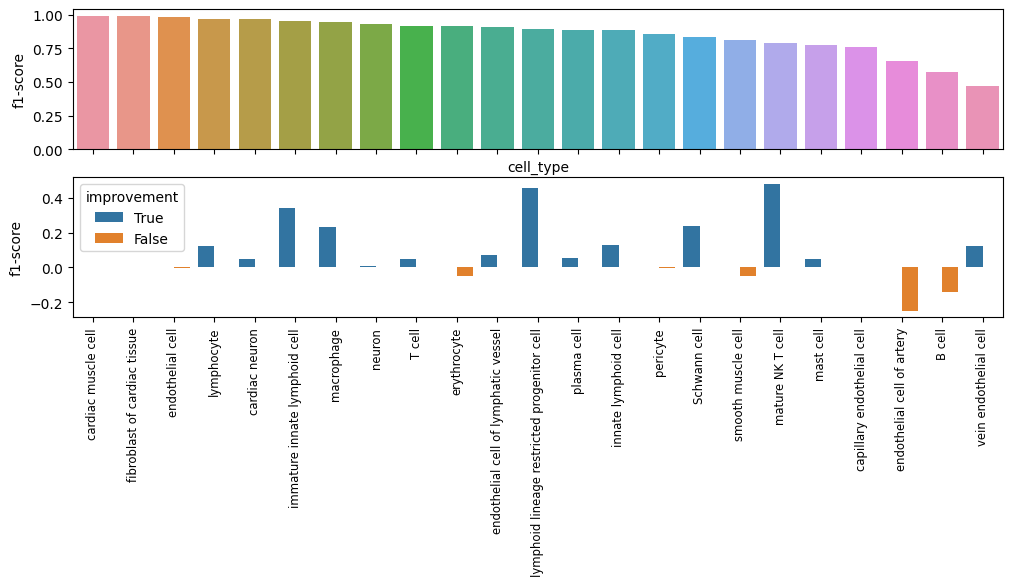

**blood_and_immune:**

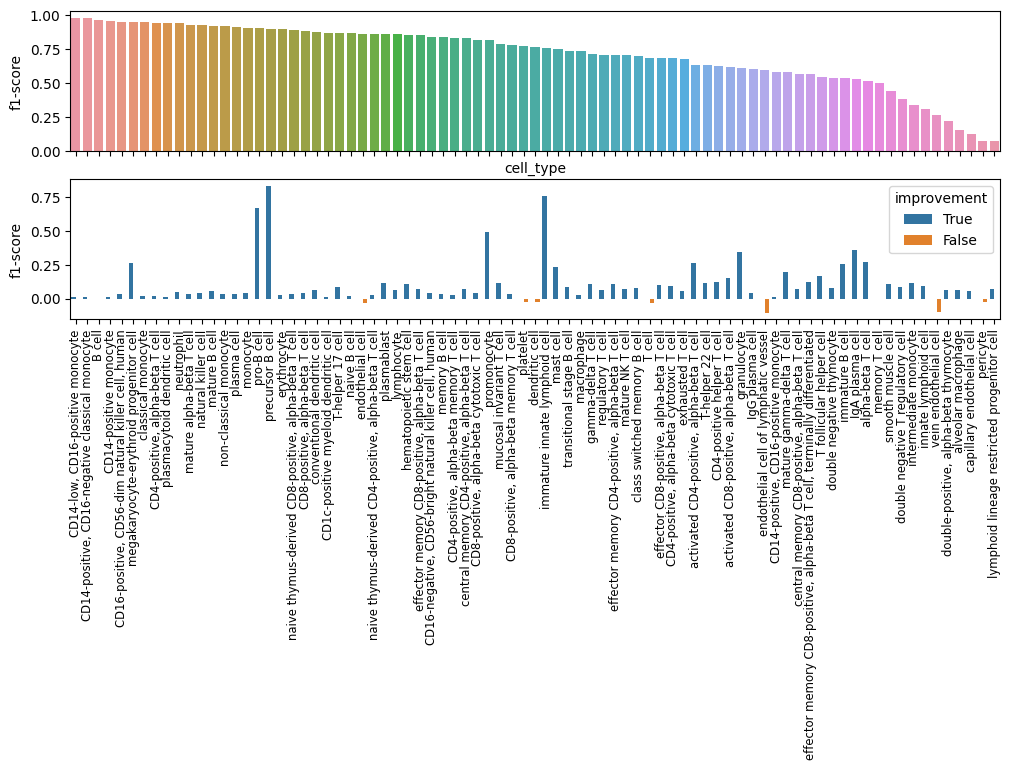

**kidney:**

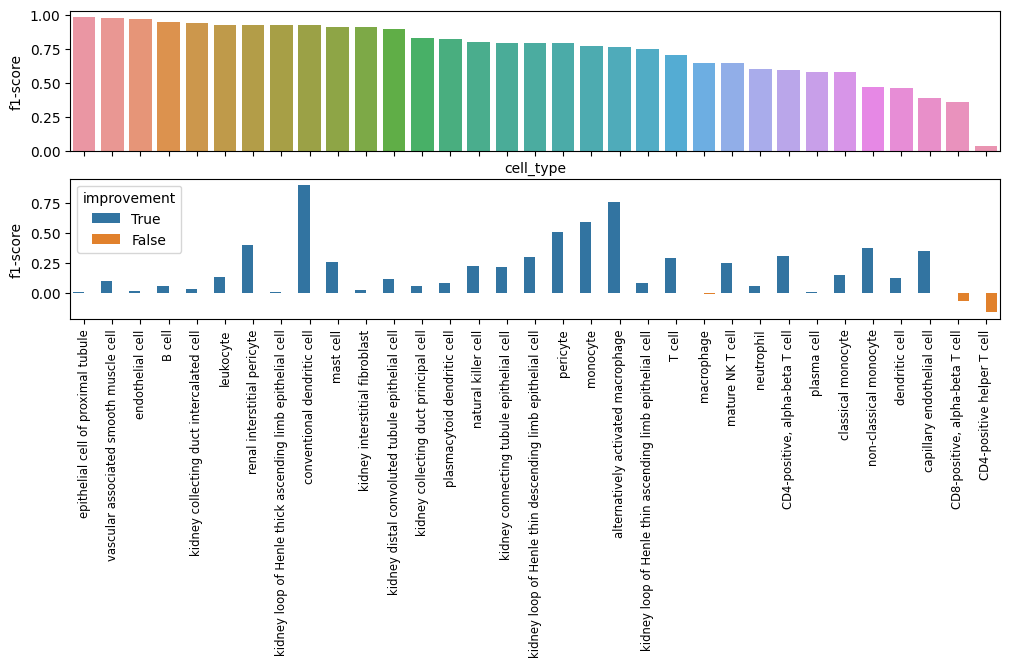

**liver:**

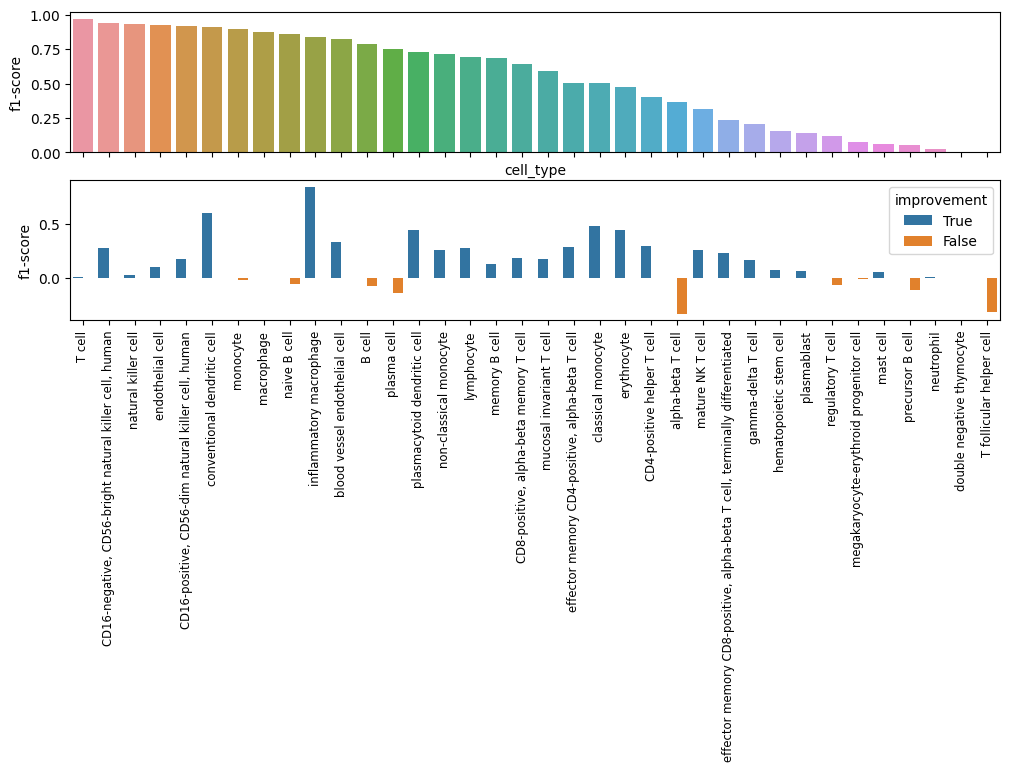

**lung:**

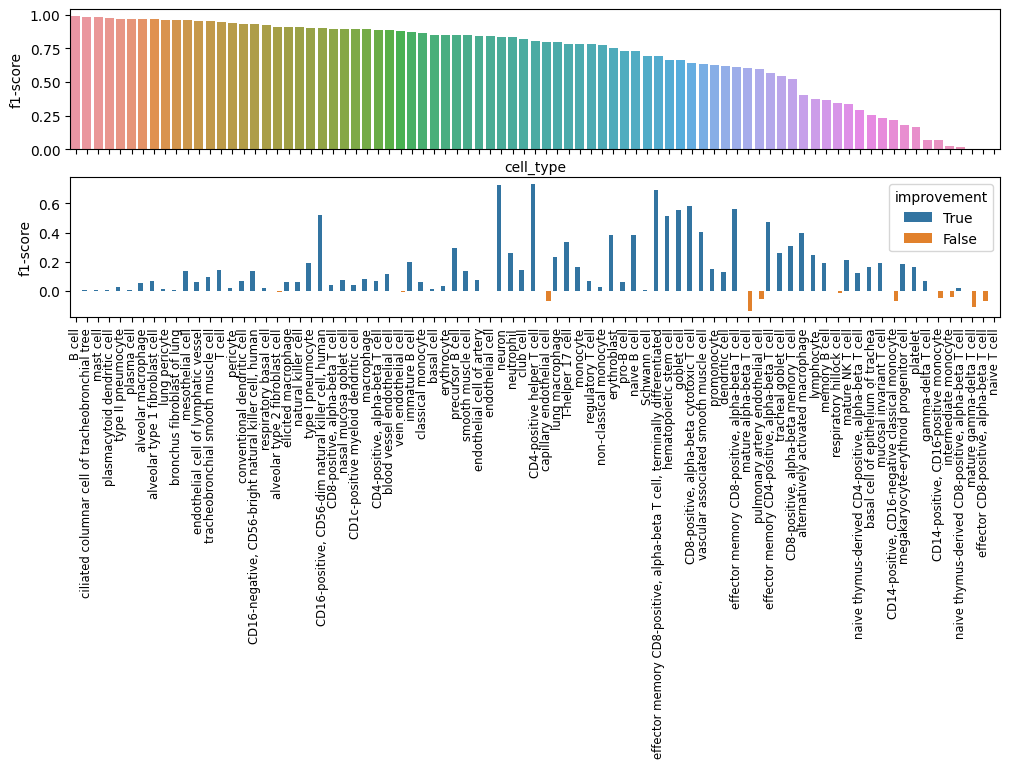

**musculoskeletal:**

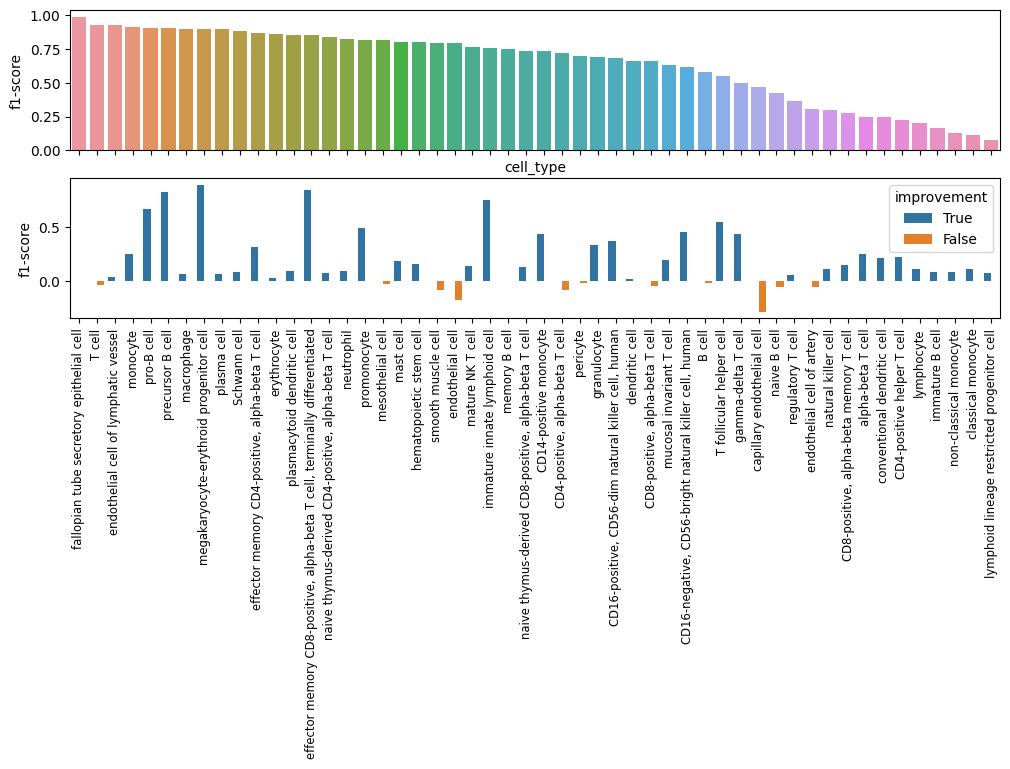

**nervous_system:**

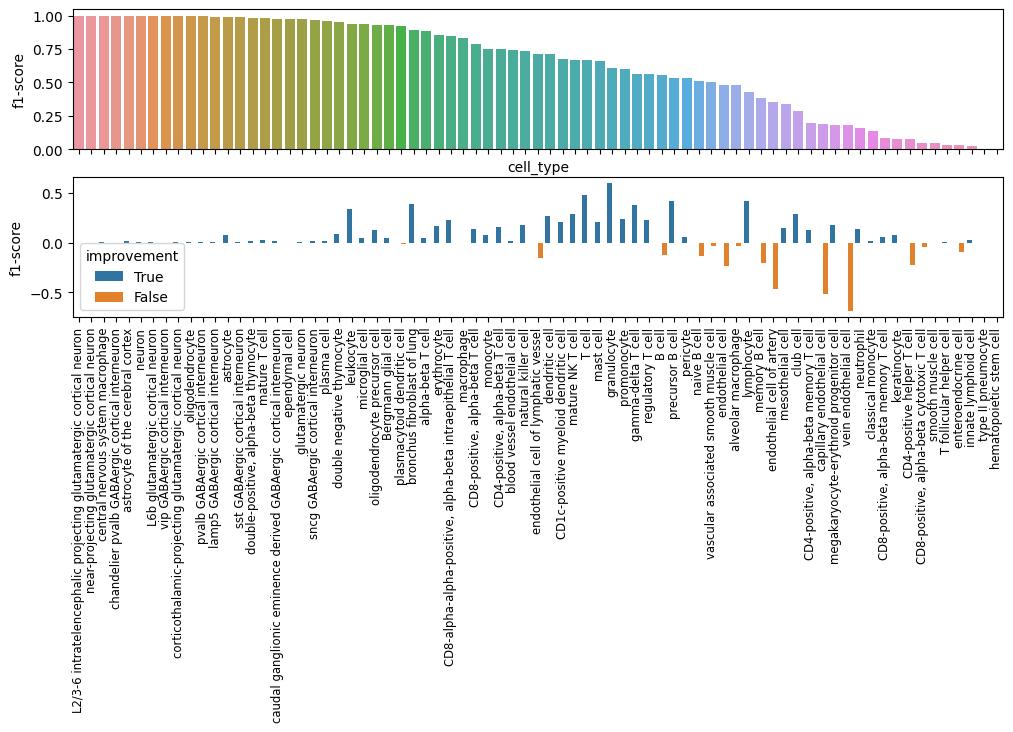

**oral_and_craniofacial:**

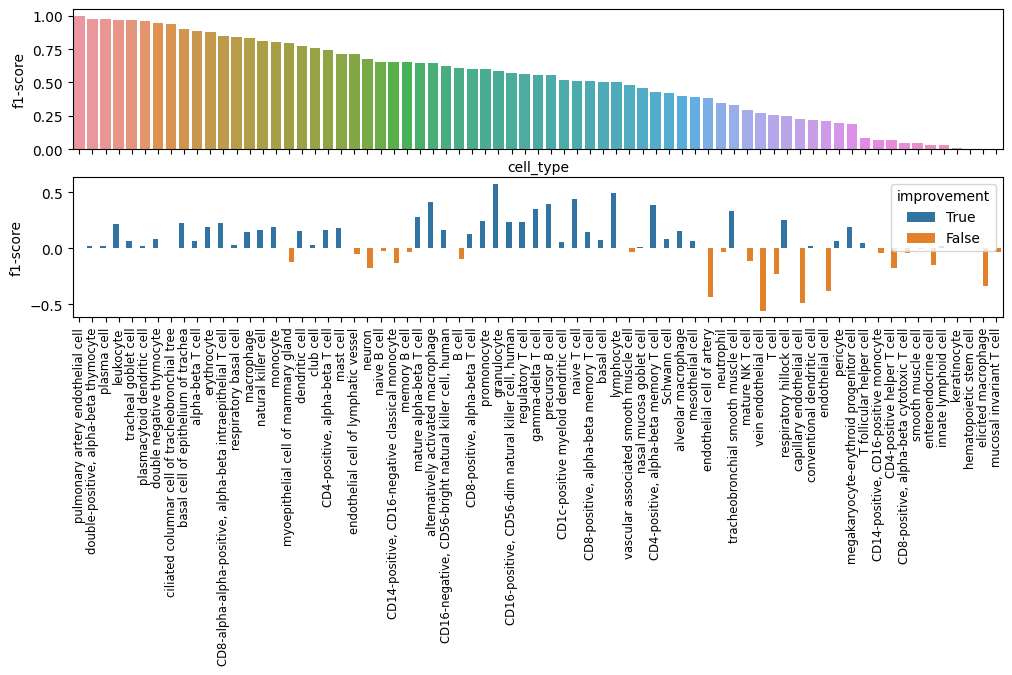

**pancreas:**

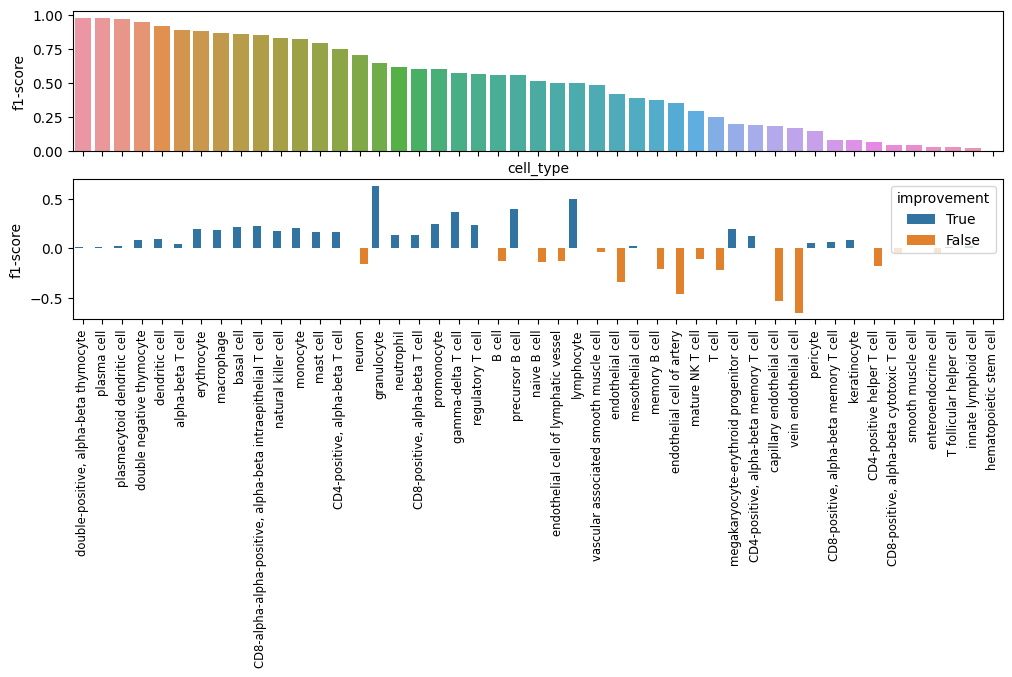

**reproduction:**

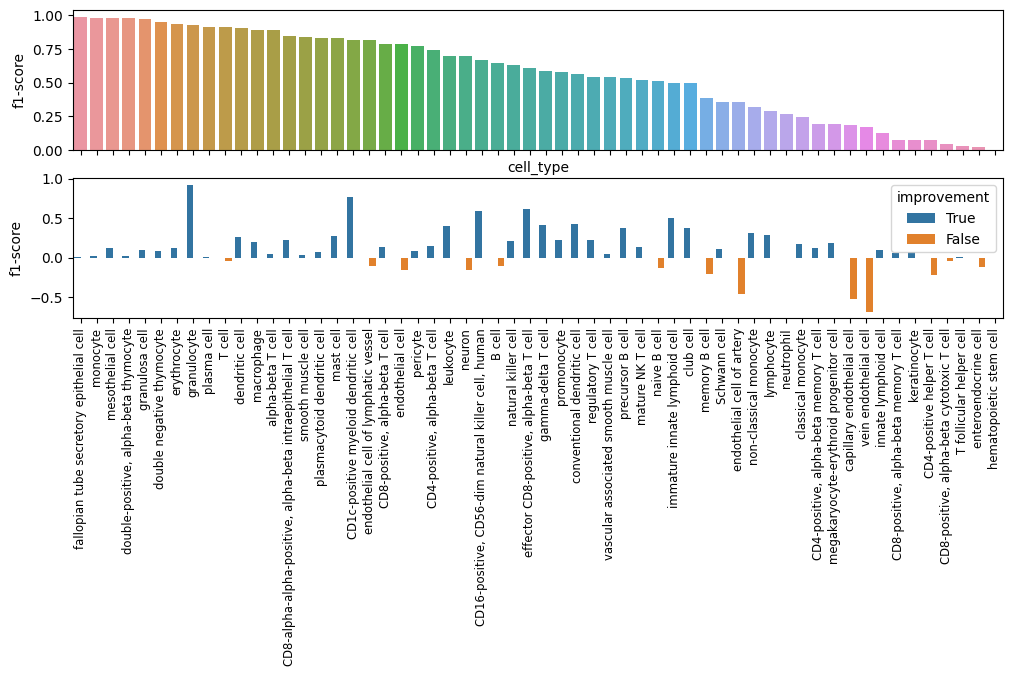

**skin:**

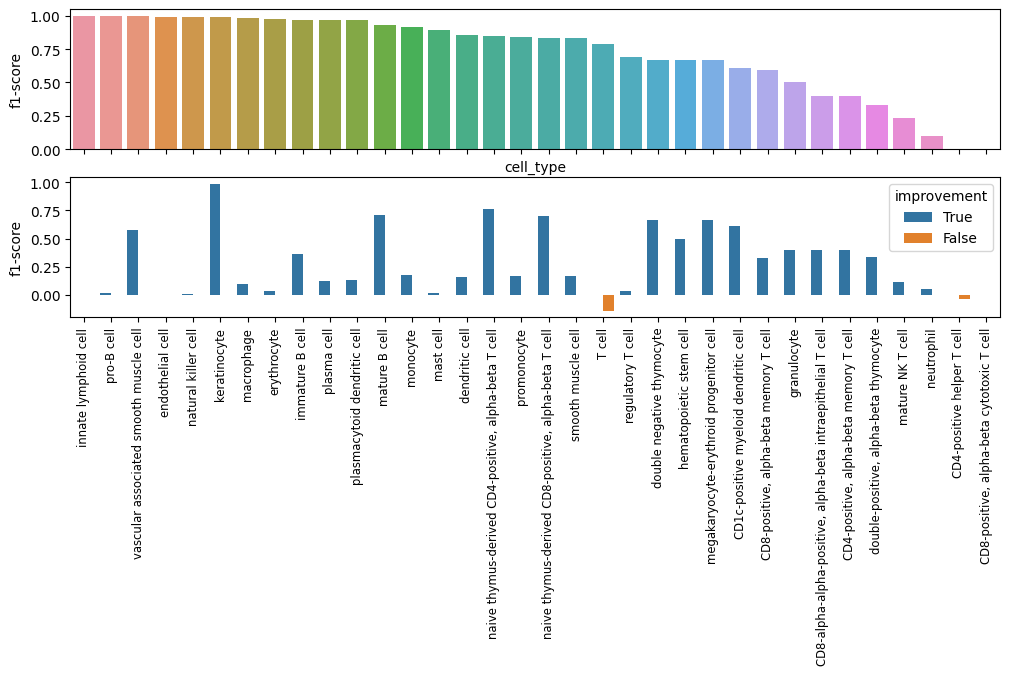

In [20]:
from IPython.display import Markdown, display


def printmd(string):
    display(Markdown(string))


for bionetwork, clf_report in clf_report_new_by_bionetwork.items():
    printmd(f'**{bionetwork}:**')
    clf_report_new_per_class = clf_report.iloc[:-3].copy()
    clf_report_old_per_class = clf_report_old_by_bionetwork[bionetwork].iloc[:-3].copy()
    clf_report_diff = pd.DataFrame({
        'f1-score': clf_report_new_per_class['f1-score'] - clf_report_old_per_class['f1-score'],
        'f1-score-new': clf_report_new_per_class['f1-score']
    }).assign(improvement=lambda df: (df['f1-score'] >= 0.))
    
    
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 4))
    sns.barplot(
        data=(
            clf_report_new_per_class
            .assign(
                cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
            )
            .sort_values('f1-score', ascending=False)
        ),
        x='cell_type',
        y='f1-score',
        ax=axs[0]
    )
    
    sns.barplot(
        data=(
            clf_report_diff
            .assign(
                cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
            )
            .sort_values('f1-score-new', ascending=False)
        ),
        x='cell_type',
        y='f1-score',
        hue='improvement',
        hue_order=[True, False],
        ax=axs[1]
    )
    
    axs[1].tick_params(axis='x', labelrotation=90)
    axs[1].xaxis.set_tick_params(labelsize='small')
    axs[1].set_xlabel('')
    plt.show()
    print('\n')
